## 4장: 밑바닥부터 GPT모델 구현하기

In [1]:
from importlib.metadata import version
print("matplotlib version: ", version("matplotlib"))
print("pytorch version: ", version("torch"))
print("tiktoken version: ", version("tiktoken"))

matplotlib version:  3.10.7
pytorch version:  2.6.0
tiktoken version:  0.11.0


In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,         # 어휘사전 크기
    "context_length": 1024,      # 문맥 길이  
    "emb_dim": 768,              # 임베딩 차원
    "n_heads": 12,               # 어텐션 헤드 개수
    "n_layers": 12,              # 층 개수
    "drop_rate": 0.1,            # dropout 비율
    "qkv_bias": False            # 쿼리, 키, 값을 만들때 편향 포함 여부
}

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        # Use a placeholder for layerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds  = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        pass
    
    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환합니다.
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 층 정규화 인터페이스를 흉내내기 위한 매개변수
    
    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환
        return x

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("출력 크기: ", logits.shape)
print(logits)

출력 크기:  torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 층 정규화로 활성화 정규화하기

- 작은 입력 샘플을 간단한 신경망 층에 통과시켜 층 정규화의 작동 방식을 알아보죠.

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
분산:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("정규화된 층 출력:\n", out_norm)
print("평균:\n", mean)
print("분산:\n", var)

정규화된 층 출력:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
평균:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
torch.set_printoptions(sci_mode=False)
print("평균:\n", mean)
print("분산:\n", var)
torch.set_printoptions(sci_mode=True)

평균:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shfit = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale*norm_x + self.shfit

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True)
print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.2499e+00],
        [1.2500e+00]], grad_fn=<VarBackward0>)


## 4.3 GELU 활성화 함수를 사용하는 피드 포워드 네트워크 구현하기

In [12]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

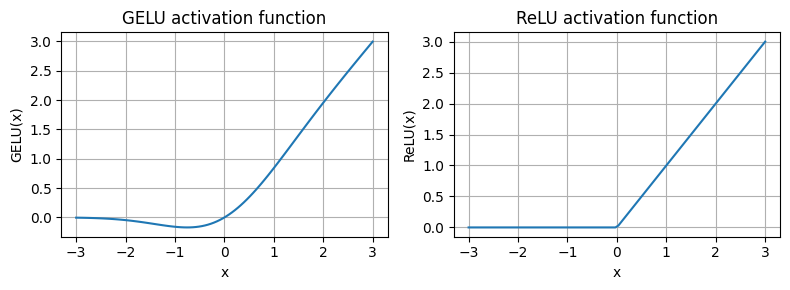

In [13]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# 샘플 데이터
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1,2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    
plt.tight_layout()
plt.show()

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
        
    def forward(self, x):
        return self.layers(x)

## 4.4 short cut 연결하기

In [15]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
        
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)     # 현재 층의 츨력을 계산합니다.
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
    
def print_gradients(model, x):
    # 정방향 계산
    output = model(x)
    target = torch.tensor([[0.]])
    
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    loss.backward()     # 그레디언트를 계산하기 위한 역전파
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            # 가중치의 그레이디언트의 평균 절대값을 출력
            print(f"{name}의 평균 그레이디언트는 {param.grad.abs().mean().item()}입니다.")

- 숏컷 연결이 없을 때 그레디언트 값을 출력

In [16]:
layer_sizes = [3,3,3,3,3,1]
simple_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_weight_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

print_gradients(model_weight_shortcut, simple_input)

layers.0.0.weight의 평균 그레이디언트는 0.00020173587836325169입니다.
layers.1.0.weight의 평균 그레이디언트는 0.00012011159560643137입니다.
layers.2.0.weight의 평균 그레이디언트는 0.0007152040489017963입니다.
layers.3.0.weight의 평균 그레이디언트는 0.0013988736318424344입니다.
layers.4.0.weight의 평균 그레이디언트는 0.005049645435065031입니다.


- 숏컷 연결이 있을 때

In [17]:
torch.manual_seed(123)
model_weight_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_weight_shortcut, simple_input)

layers.0.0.weight의 평균 그레이디언트는 0.22169798612594604입니다.
layers.1.0.weight의 평균 그레이디언트는 0.20694111287593842입니다.
layers.2.0.weight의 평균 그레이디언트는 0.3289700150489807입니다.
layers.3.0.weight의 평균 그레이디언트는 0.26657330989837646입니다.
layers.4.0.weight의 평균 그레이디언트는 1.3258544206619263입니다.


## 4.5 어텐션과 선형 층을 트랜스포머 블록에 연결하기

In [18]:
from previous_chapter import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x    # 피드 포워드 신경망을 위한 숏컷 연결
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x
        

In [19]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("입력 크기: ", x.shape)
print("출력 크기: ", output.shape)

입력 크기:  torch.Size([2, 4, 768])
출력 크기:  torch.Size([2, 4, 768])


## 4.6 GPT 모델 만들기

In [22]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds   # 크기: [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [23]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("입력 배치:\n", batch)
print("\n출력 크기:", out.shape)
print(out)

입력 배치:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

출력 크기: torch.Size([2, 4, 50257])
tensor([[[1.3811e-01, 7.7019e-03, -1.9629e-01,  ..., -2.2219e-02, -1.0602e-01, 1.7167e-01],
         [3.8647e-01, -8.4080e-01, -6.5640e-01,  ..., -5.1632e-01, 2.3690e-01, -3.3575e-01],
         [6.9885e-01, -1.8290e-01, -1.6308e-01,  ..., 1.4722e-01, -6.5041e-01, -5.6423e-03],
         [-4.2903e-01, 1.6689e-01, -1.2580e-01,  ..., 1.1579e+00, 5.3034e-01, -5.5489e-01]],

        [[1.0935e-01, -2.8938e-01, -1.4672e-01,  ..., -5.5736e-02, 2.9106e-01, -2.8236e-01],
         [8.8244e-02, -3.5518e-01, -3.5270e-01,  ..., 1.2930e+00, 5.3326e-03, 1.8979e-01],
         [6.0914e-01, 4.7020e-01, -4.0944e-01,  ..., 7.6885e-01, 3.7874e-01, -1.9740e-01],
         [-6.1167e-02, -7.3710e-02, 4.7506e-01,  ..., 1.2463e+00, -3.8341e-01, 6.0876e-02]]],
       grad_fn=<UnsafeViewBackward0>)


In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f"총 파라미터 개수: {total_params} ")

총 파라미터 개수: 163009536 


In [26]:
print("토큰 임베딩 층 크기: ", model.tok_emb.weight.shape)
print("출력 층 크기: ", model.out_head.weight.shape)

토큰 임베딩 층 크기:  torch.Size([50257, 768])
출력 층 크기:  torch.Size([50257, 768])


In [28]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"가중치 묶기를 고려한 훈련 가능한 파라미터 개수: {total_params_gpt2:,}")

가중치 묶기를 고려한 훈련 가능한 파라미터 개수: 124,412,160


In [29]:
# 총 크기를 바이트 단위로 계산합니다(float32라 가정하면 파라미터당 4바이트입니다).
total_size_bytes = total_params * 4

# 메가바이트로 변환합니다.
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"모델에 필요한 메모리 공간: {total_size_mb:.2f} MB")

모델에 필요한 메모리 공간: 621.83 MB


## 4.7 텍스트 생성하기

In [30]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx는 현재 문맥이 담긴 (batch, n_tokens) 크기의 배열입니다.
    for _ in range(max_new_tokens):
        # 현재 문맥이 모델이 지원하는 문맥 크기를 초과하면 잘라냅닏.
        # 예를 들어, LLM이 5개 토크만 지원하고 문맥 크기가 10이라면,
        # 마지막 5개 토큰만 문맥으로 사용합니다.
        idx_cond = idx[:, -context_size:]
        
        # 예측을 만듭니다.
        with torch.no_grad():
            logits = model(idx_cond)
            
        # 마지막 타임 스텝만 사용하므로
        # (batch, n_token, vocab_size) -> (batch, vocab_size)
        logits = logits[:, -1, :]
        
        # 확률을 얻기 위해 softmax 적용
        probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
        
        # 가장 높은 확률 값을 가진 항목의 인덱스를 얻습니다.
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        
        # 선택한 인덱스를 현재 시퀀스에 추가합니다.
        idx = torch.cat((idx, idx_next), dim=1)     # (batch, n_tokens+1)
        
        return idx
        

In [31]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("인코딩된 ID: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape: ", encoded_tensor.shape)

인코딩된 ID:  [15496, 11, 314, 716]
encoded_tensor.shape:  torch.Size([1, 4])


In [32]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력:", out)
print("출력 길이:", len(out[0]))

출력: tensor([[15496,    11,   314,   716, 27018]])
출력 길이: 5


In [33]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Feature
